In [22]:
import os
import re

import random
import numpy as np
import matplotlib.pyplot as plt

from torchinfo import summary

import torch
from torch import nn
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchvision.transforms.functional import convert_image_dtype

from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import make_grid

from torchvision.ops import sigmoid_focal_loss

import pytorch_lightning as pl

import pl_bolts
#from pl_bolts.models.vision import UNet

from pytorch_lightning.callbacks import EarlyStopping

import torchmetrics as tm

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

Think about pre and post processing with computer vision approaches.
E.g.  
For Preprocessing: Use feature extraction like line detection as potential features into the network.  
For Postprocessing: Define clear edges and connect segments if enough is predicted to be a road.

# 1. Preparation

In [40]:
batch_size = 16
num_workers = 8

## 1.1 DataModule

In [12]:
transforms_img = T.Compose(
    [
        T.RandomEqualize(p=1.0),
        T.GaussianBlur(3, 5),
        T.RandomAdjustSharpness(3, 1),
    ]
)

In [13]:
def randomAugmentations(img, mask):    
    if random.random() > 0.5:
        angle = T.RandomRotation(degrees=(0, 360)).get_params([0, 360])

        img = F.rotate(img, angle)
        mask = F.rotate(mask, angle)
        
    if random.random() > 0.5:
        img = F.hflip(img)
        mask = F.hflip(mask)
        
    if random.random() > 0.5:
        img = F.vflip(img)
        mask = F.vflip(mask)
        
    return img, mask

In [14]:
class RoadSatelliteSet(Dataset):
    def __init__(self, dataset, transform_img=None, transform_tuple=None):
        self.dataset = dataset
        
        self.transform_img = transform_img
        self.transform_tuple = transform_tuple

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        
        if self.transform_img:
            img = self.transform_img(img)
            
        if self.transform_tuple:
            img, mask = self.transform_tuple(img, mask)

        return (img, mask)

In [41]:
class RoadSatelliteModule(pl.LightningDataModule):
    
    def __init__(self, batch_size: int = batch_size, num_workers: int = num_workers):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def prepare_data(self):
        self.train_images = self.read_images('cil_data/training/training/images/', ImageReadMode.RGB)
        self.train_masks = self.read_images('cil_data/training/training/groundtruth/', ImageReadMode.GRAY)
    
        for i, train_mask in enumerate(self.train_masks):
            self.train_masks[i][self.train_masks[i] > 0] = 1  # 255
            
        # self.train_images_float = [convert_image_dtype(img, dtype=torch.float) for img in self.train_images]
        # self.train_masks_float = [convert_image_dtype(img, dtype=torch.float) for img in self.train_masks]
            
        self.train_zip = list(zip(self.train_images, self.train_masks)) # _float
        
        test_files = [(x[0], x[2]) for x in os.walk('cil_data/test_images/test_images/')]
        self.file_names = test_files[0][1]
        self.test_images = list()
        for file_name in self.file_names:
            self.test_images.append(read_image(str('cil_data/test_images/test_images/' + file_name), ImageReadMode.RGB))
        
    def setup(self, stage=None):
        if stage in (None, 'fit'):
            train_length = int(len(self.train_zip) * 0.8)
            valid_length = len(self.train_zip) - train_length

            self.train_data, self.valid_data = random_split(self.train_zip, [train_length, valid_length])
            
            self.train_dataset = RoadSatelliteSet(self.train_data, transforms_img, randomAugmentations)
            self.valid_dataset = RoadSatelliteSet(self.valid_data, transforms_img)
            
        if stage in (None, 'test'):
            self.test_data = list(zip(self.test_images, self.file_names))
            
            self.test_dataset = RoadSatelliteSet(self.test_data, transforms_img)
                
            
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=True,
            drop_last=True,
            pin_memory=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=True,
            pin_memory=True
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )
    
    def read_images(self, data_dir, read_mode):
        return [read_image(data_dir + file, read_mode) for file in os.listdir(data_dir)]

In [42]:
road_data = RoadSatelliteModule()

In [43]:
road_data.prepare_data()
road_data.setup()

## 1.2 Inspect data

In [18]:
def show_image(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [27]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def mask_to_patched_mask(image):
    patched_image = image.squeeze().detach().clone()
    image = np.asarray(image.squeeze())
    patch_size = 16
    for j in range(0, image.shape[1], patch_size):
        for i in range(0, image.shape[0], patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            patched_image[i:i + patch_size, j:j + patch_size] = label
    return patched_image

def mask_to_submission_strings(im, name):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", name).group(0))
    #im = mpimg.imread(image_filename) 
    # image is gray scale therefore size MxN with imread 
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *images):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for imgs, fn in images[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(imgs, fn))

In [28]:
seg_images = [draw_segmentation_masks(
                image=train_pair[0], masks=train_pair[1].bool(),
                alpha=0.6,
                colors=["#00FF00"]
              ) 
              for train_pair in road_data.train_zip]

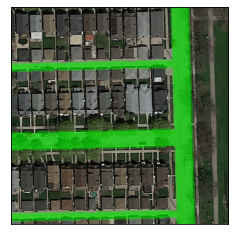

In [29]:
show_image(seg_images[69])

#for seg_image in seg_images:
#    show_image(seg_image)

In [30]:
X, y = next(iter(road_data.train_dataloader()))
print("Shapes:\nX: ", X.shape, "\ny: ", y.shape)
print("Types:\nX type: ", X.type(), "\ny type: ", y.type())
print("Datatypes:\nX dtype: ", X[0].dtype, "\ny dtype: ", y[0].dtype)

Shapes:
X:  torch.Size([16, 3, 400, 400]) 
y:  torch.Size([16, 1, 400, 400])
Types:
X type:  torch.ByteTensor 
y type:  torch.ByteTensor
Datatypes:
X dtype:  torch.uint8 
y dtype:  torch.uint8


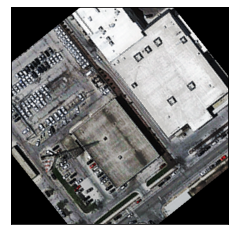

In [31]:
show_image(X[0])

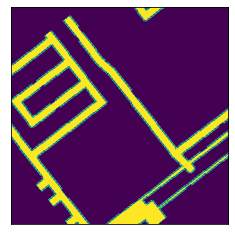

In [32]:
show_image(y[0])

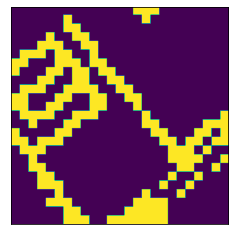

In [33]:
show_image(mask_to_patched_mask(y[0]))

In [37]:
tx, ty = next(iter(road_data.test_dataloader()))

In [38]:
print("tx: ", tx.shape)
print("ty: ", len(ty))
# print("Test Image ", ty[0], " has tensor:\n", tx[0])

tx:  torch.Size([16, 3, 608, 608])
ty:  16


# 2. System

In [39]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [45]:
class SemanticSegmentationSystem(pl.LightningModule):
    def __init__(self, model: nn.Module, datamodule: pl.LightningDataModule, lr: float = 2e-4, batch_size: int = batch_size):
        super().__init__()
        
        self.model = model
        self.datamodule = datamodule
        
        self.lr = lr
        self.batch_size = batch_size
        
        self.save_hyperparameters()
        

    def training_step(self, batch, batch_idx):
        X, y = batch
        
        X = X.float()
        y = y.float()
        
        y_pred = self.model(X)
       
        loss = sigmoid_focal_loss(y_pred, y, reduction='mean')
        
        self.log('training_loss', loss)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        
        X = X.float()
        y = y.int()
        
        y_pred = self.model(X)
        y_sig = torch.sigmoid(y_pred)
       
        metric = tm.functional.accuracy(y_sig, y)
        
        self.log('validation_metric', metric)
        
        return metric
    
    def test_step(self, batch, batch_idx):
        X, name = batch
        
        X = X.float()
        
        return (self.model(X), name)
    
    def test_epoch_end(self, outputs):
        self.test_results = outputs
            
    def train_dataloader(self):
        return self.datamodule.train_dataloader()

    def val_dataloader(self):
        return self.datamodule.val_dataloader()

    def test_dataloader(self):
        return self.datamodule.test_dataloader()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=2)
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'validation_metric'
        }
    
    @torch.no_grad()
    def visualize_results(self):
            Xs, ys = next(iter(self.val_dataloader()))
            
            y_preds = torch.sigmoid(self.model(Xs.float()))
            
            for y_pred in y_preds:
                show_image(y_pred)

    @torch.no_grad()
    def visualize_results_overlay(self):
        Xs, ys = next(iter(self.val_dataloader()))
        
        y_preds = torch.sigmoid(self.model(Xs.float()))
        
        pred_zip = list(zip(Xs, y_preds))
        
        seg_images = [draw_segmentation_masks(train_pair[0], train_pair[1].round().bool(), alpha=0.6, colors=['#00ff00']) for train_pair in pred_zip]
        
        for seg_image in seg_images:
            show_image(seg_image)
            

# 3. Model

In [46]:
class Conv2d(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 1, 5, padding='same')
        )
        
    def forward(self, X):
        X = X.float()
        return self.model(X)

In [47]:
model = Conv2d()

In [48]:
#model = UNet(1, 3, 5, 12)  #UNet form pytorch-lightning-bolts

### Spatially dependent (nested) u-net

In [49]:
# get unet implementation: 
#     https://idiotdeveloper.com/unet-implementation-in-pytorch/
#     https://github.com/4uiiurz1/pytorch-nested-unet/blob/master/archs.py
# augment with spatial layers: 
#     https://github.com/djordjemila/sdn/blob/main/lib/nn.py
# augment with dialation: 
#     https://arxiv.org/pdf/2004.03466.pdf

In [66]:
class SDNCell(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.gru = nn.GRUCell(input_size=3*num_features, hidden_size=num_features)

    def forward(self, neighboring_features, features):
        """ Update current features based on neighboring features """
        return self.gru(torch.cat(neighboring_features, dim=1), features)


class _CorrectionLayer(nn.Module):

    def __init__(self, num_features, dir=0):
        super().__init__()
        self.num_features = num_features
        self.cell = SDNCell(num_features)
        if dir == 0:
            self.forward = self.forward0
        elif dir == 1:
            self.forward = self.forward1
        elif dir == 2:
            self.forward = self.forward2
        else:
            self.forward = self.forward3
        self.zero_pad = None

    def _get_zero_pad(self, batch, device):
        if self.zero_pad is None or self.zero_pad.shape[0] != batch:
            self.zero_pad = torch.zeros((batch, self.num_features, 1), device=device)  # no grad ??
        return self.zero_pad

    def forward0(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(1, dim):
            neighboring_features = torch.cat([zero_pad, features[:, :, :, d - 1], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, :, d] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, :, d].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward1(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(dim - 2, -1, -1):
            neighboring_features = torch.cat([zero_pad, features[:, :, :, d + 1], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, :, d] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, :, d].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward2(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(1, dim):
            neighboring_features = torch.cat([zero_pad, features[:, :, d - 1, :], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, d, :] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, d, :].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features

    def forward3(self, features):
        batch = features.shape[0]
        dim = features.shape[2]
        zero_pad = self._get_zero_pad(batch, features.device)
        # make a loop
        for d in range(dim - 2, -1, -1):
            neighboring_features = torch.cat([zero_pad, features[:, :, d + 1, :], zero_pad], dim=2).transpose(1, 2)
            # compute features
            features[:, :, d, :] = self.cell(
                neighboring_features=[neighboring_features[:, :-2, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 1:-1, :].reshape(-1, self.num_features),
                                      neighboring_features[:, 2:, :].reshape(-1, self.num_features)],
                features=features[:, :, d, :].transpose(1, 2).reshape(-1, self.num_features).clone()
            ).reshape(batch, -1, self.num_features).transpose(1, 2)
        # return new features
        return features


class SDNLayer(nn.Module):
    def __init__(self, in_ch, out_ch, num_features, dirs, kernel_size, stride, padding, upsample):
        super().__init__()
        # project-in network
        cnn_module = nn.ConvTranspose2d if upsample else nn.Conv2d
        self.project_in_stage = cnn_module(in_ch, num_features, kernel_size, stride, padding)
        # correction network
        sdn_correction_layers = []
        for dir in dirs:
            sdn_correction_layers.append(_CorrectionLayer(num_features, dir=dir))
        self.sdn_correction_stage = nn.Sequential(*sdn_correction_layers)
        # project-out network
        self.project_out_stage = nn.Conv2d(num_features, out_ch, 1)

    def forward(self, x):
        # (I) project-in stage
        x = self.project_in_stage(x)
        x = torch.tanh(x)
        # (II) correction stage
        x = x.contiguous(memory_format=torch.channels_last)
        x = self.sdn_correction_stage(x)
        x = x.contiguous(memory_format=torch.contiguous_format)
        # (III) project-out stage
        x = self.project_out_stage(x)
        return x


class ResSDNLayer(nn.Module):

    def __init__(self, in_ch, out_ch, num_features, dirs, kernel_size, stride, padding, upsample):
        super().__init__()
        self.sdn = SDNLayer(in_ch, 2 * out_ch, num_features, dirs, kernel_size, stride, padding, upsample)
        cnn_module = nn.ConvTranspose2d if upsample else nn.Conv2d
        self.cnn = cnn_module(in_ch, out_ch, kernel_size, stride, padding)

    def forward(self, input):
        cnn_out = self.cnn(input)
        sdn_out, gate = self.sdn(input).chunk(2, 1)
        gate = torch.sigmoid(gate)
        return gate * cnn_out + (1-gate) * sdn_out

In [67]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [68]:
class spatial_block(nn.Module):
    def __init__(self, in_c, out_c, upsample=False):
        super().__init__()

        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.spatial = ResSDNLayer(out_c, out_c, 16, range(4), 3, 1, 1, upsample)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.spatial(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [136]:
class dialated_spatial_block(nn.Module):
    def __init__(self, in_c, out_c, upsample=False):
        super().__init__()

        self.conv = nn.Conv2d(in_c, out_c//2, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c//2)
        
        
        self.dial3 = nn.Conv2d(out_c//2, out_c//4, kernel_size=3, padding=3, dilation=3)
        self.bn2_1 = nn.BatchNorm2d(out_c//4)
        
        self.dial6 = nn.Conv2d(out_c//4, out_c//8, kernel_size=3, padding=6, dilation=6)
        self.bn2_2 = nn.BatchNorm2d(out_c//8)

        self.dial9 = nn.Conv2d(out_c//8, out_c//16, kernel_size=3, padding=9, dilation=9)
        self.bn2_3 = nn.BatchNorm2d(out_c//16)

        self.dial12 = nn.Conv2d(out_c//16, out_c//16, kernel_size=3, padding=12, dilation=12)
        self.bn2_4 = nn.BatchNorm2d(out_c//16)
        

        self.spatial = ResSDNLayer(out_c, out_c, 16, range(4), 3, 1, 1, upsample)
        self.bn3 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        #print(x.shape)
        
        z1=self.dial3(x)
        z1=self.bn2_1(z1)
        z1=self.relu(z1)
        #print(z1.shape)
        
        z2=self.dial6(z1)
        z2=self.bn2_2(z2)
        z2=self.relu(z2)
        #print(z2.shape)
        
        z3=self.dial9(z2)
        z3=self.bn2_3(z3)
        z3=self.relu(z3)
        #print(z3.shape)
        
        z4=self.dial12(z3)
        z4=self.bn2_4(z4)
        z4=self.relu(z4)
        #print(z4.shape)
        
        z = torch.cat([x, z1, z2, z3, z4], 1)

        x = self.spatial(z)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [137]:
dblock = dialated_spatial_block(3, 16)

In [138]:
cblock = conv_block(3, 16)

In [139]:
X.dtype

torch.uint8

In [ ]:
dblock(X.float())

torch.Size([16, 8, 400, 400])
torch.Size([16, 4, 400, 400])
torch.Size([16, 2, 400, 400])
torch.Size([16, 1, 400, 400])
torch.Size([16, 1, 400, 400])


In [69]:
class SDUNet(nn.Module):
    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()

        #nb_filter = [32, 64, 128, 256, 512]
        nb_filter = [16, 32, 64, 128, 256]
        
        down_upsample = False
        up_upsample = True
        
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.spatial0_0 = spatial_block(input_channels, nb_filter[0])
        self.conv1_0 = conv_block(nb_filter[0], nb_filter[1])
        self.spatial2_0 = spatial_block(nb_filter[1], nb_filter[2])
        self.spatial3_0 = spatial_block(nb_filter[2], nb_filter[3])
        self.spatial4_0 = spatial_block(nb_filter[3], nb_filter[4])

        self.spatial3_1 = spatial_block(nb_filter[3]+nb_filter[4], nb_filter[3])
        self.spatial2_2 = spatial_block(nb_filter[2]+nb_filter[3], nb_filter[2])
        self.conv1_3 = conv_block(nb_filter[1]+nb_filter[2], nb_filter[1])
        self.spatial0_4 = spatial_block(nb_filter[0]+nb_filter[1], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)


    def forward(self, input):
        x0_0 = self.spatial0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.spatial2_0(self.pool(x1_0))
        x3_0 = self.spatial3_0(self.pool(x2_0))
        
        x4_0 = self.spatial4_0(self.pool(x3_0))
        
        x3_1 = self.spatial3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.spatial2_2(torch.cat([x2_0, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, self.up(x2_2)], 1))
        x0_4 = self.spatial0_4(torch.cat([x0_0, self.up(x1_3)], 1))

        output = self.final(x0_4)
        return output

In [70]:
model = SDUNet(1, 3)

In [71]:
system = SemanticSegmentationSystem(model, road_data)

# 4. Inspect System and Model

In [72]:
summary(model, input_size=(system.batch_size, 3, 400, 400))

/home/cupcake/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                                  Output Shape              Param #
SDUNet                                                  --                        --
├─spatial_block: 1-1                                    [16, 16, 400, 400]        --
│    └─Conv2d: 2-1                                      [16, 16, 400, 400]        448
│    └─BatchNorm2d: 2-2                                 [16, 16, 400, 400]        32
│    └─ReLU: 2-3                                        [16, 16, 400, 400]        --
│    └─ResSDNLayer: 2-4                                 [16, 16, 400, 400]        --
│    │    └─Conv2d: 3-1                                 [16, 16, 400, 400]        2,320
│    │    └─SDNLayer: 3-2                               [16, 32, 400, 400]        15,536
│    └─BatchNorm2d: 2-5                                 [16, 16, 400, 400]        32
│    └─ReLU: 2-6                                        [16, 16, 400, 400]        --
├─MaxPool2d: 1-2                                    

## 4.1 Shapes and Types

In [ ]:
y_pred = model(X.float())
y_pred.shape

In [ ]:
system.training_step((X, y), 0)

In [ ]:
system.validation_step((X, y), 0)

## 4.2 Visual

In [ ]:
#system.visualize_results_overlay()

In [ ]:
#system.visualize_results()

# 5. Training

In [ ]:
early_stop_callback = EarlyStopping(
   monitor='validation_metric',
   patience=5,
   verbose=2,
   mode='max'
)

In [ ]:
if torch.cuda.is_available():
    gpu_count = -1
    print("GPUs detected.")
    print("There should be ", torch.cuda.device_count(), " GPUs available.")
else:
    gpu_count = 0
    print("No GPU detected.")
    print("Working with CPU")

gpu_count

In [ ]:
trainer = pl.Trainer(
    #fast_dev_run=True,
    #max_epochs = 1,  # at least 1 requried. Only for testing the prediction
    gpus=gpu_count,
    auto_lr_find=True,
    auto_scale_batch_size='binsearch',
    stochastic_weight_avg=True,
    logger=False,
    deterministic=True,
    callbacks=[early_stop_callback]
)

In [ ]:
system.hparams

In [ ]:
# trainer.tune(system)

In [ ]:
trainer.fit(system)

# 6.Predict Data

In [ ]:
predictions = trainer.test()

In [ ]:
batches = system.test_results

In [ ]:
len(batches)

In [ ]:
batches[0][0].shape

In [25]:
submission_filename = "some_predictions.csv"

In [26]:
pred_counter = 0

with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        # iterate over batches and get the ids and predictions
        for masks, names in batches:
            for i, mask in enumerate(masks):
                #print("mask ", i, " is: ", names[i])
                predicted_mask = np.asarray(torch.sigmoid(mask).squeeze())

                ids = mask_to_submission_strings(predicted_mask, names[i])
                # print('\n'.join(id))
                f.writelines('{}\n'.format('\n'.join(ids)))

                pred_counter += 1
pred_counter

NameError: name 'batches' is not defined

# 7. Inspect Results

In [ ]:
system.visualize_results_overlay()

In [ ]:
system.visualize_results()

# 8. Scratch Area to try out things at the bottom

In [ ]:
class SDUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Spatial Depenent Layers
        
        # Convolutional Layer
        # also try dialated for longer reach 
        
        
        self.model = nn.Sequential(
            
        )
        
    def forward(self, X):
        X = X.float()
        return self.model(X)